In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ecephys import wne
from findlay2025a import core, dentate_spikes, sharp_waves

In [2]:
nbsh = core.get_project("seahorse")

In [ ]:
def do_experiment(sglx_subject: wne.sglx.SGLXSubject, experiment: str):
    spws = sharp_waves.read_spws(sglx_subject.name, experiment, kind="postprocessed")
    dspks = dentate_spikes.read_dspks(
        sglx_subject.name, experiment, kind="postprocessed"
    )
    t_spw = spws["pk_time"].values
    t_dspk = dspks["peak_time"].values
    # Count SPWs within +/- 0.050 seconds of each DSPK
    spw_counts = []
    window = 0.050  # 50 ms window

    for dspk_time in t_dspk:
        # Find SPWs within the time window around this DSPK
        time_diff = np.abs(t_spw - dspk_time)
        spws_in_window = np.sum(time_diff <= window)
        spw_counts.append(spws_in_window)

    # Add the counts to the dspks dataframe
    dspks["spw_count"] = spw_counts
    dspks["has_spw"] = dspks["spw_count"] > 0

    return dspks


def do_project():
    dspks_dfs = []
    for sglx_subject, experiment in core.yield_sglx_subject_experiment_pairs():
        dspks = do_experiment(sglx_subject, experiment)
        dspks["subject"] = sglx_subject.name
        dspks["experiment"] = experiment
        print(f"Subject: {sglx_subject.name}, Experiment: {experiment}")
        print(f"Proportion of DSs with SPWs: {dspks['has_spw'].sum() / len(dspks)}")
        dspks_dfs.append(dspks)
    return pd.concat(dspks_dfs, ignore_index=True)


ds1 = do_project()

Subject: CNPIX2-Segundo, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.04551664529080466
Subject: CNPIX3-Valentino, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.10873690289580068
Subject: CNPIX4-Doppio, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.14168919364409574
Subject: CNPIX5-Alessandro, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.09894359892569382
Subject: CNPIX6-Eugene, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.029011669138031073
Subject: CNPIX8-Allan, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.0873420527599202
Subject: CNPIX9-Luigi, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.031080965055379068
Subject: CNPIX10-Charles, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.127515567187077
Subject: CNPIX11-Adrian, Experiment: novel_objects_deprivation
Proportion of DSs with SPWs: 0.08293082275

In [4]:
ds1["has_spw"].sum() / len(ds1)

np.float64(0.08301075627966566)

In [5]:
colorblind_palette = sns.color_palette("colorblind")
state_colors = {
    "Wake": colorblind_palette[2],
    "NREM": colorblind_palette[0],
    "IS": colorblind_palette[3],
    "REM": colorblind_palette[1],
}

/home/gfindlay/projects/ece/gfys_workspace/.venv/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/gfindlay/projects/ece/gfys_workspace/.venv/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/gfindlay/projects/ece/gfys_workspace/.venv/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/home/gfindlay/projects/ece/gfys_workspace/.venv/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use

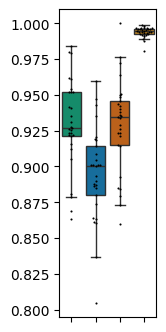

In [6]:
grpd = ds1.groupby(["subject", "experiment", "state"])
ds1_props = (grpd["has_spw"].sum() / grpd["has_spw"].count()).reset_index()
ds1_props["no_spw"] = 1 - ds1_props["has_spw"]
fig, ax = plt.subplots(figsize=(1.25, 4))
sns.boxplot(
    data=ds1_props,
    y="no_spw",
    x="state",
    order=list(state_colors.keys()),
    fliersize=0,
    linewidth=1.0,
    hue="state",
    hue_order=list(state_colors.keys()),
    palette=state_colors,
    ax=ax,
)
sns.swarmplot(
    data=ds1_props,
    y="no_spw",
    x="state",
    color="black",
    s=1.5,
    order=list(state_colors.keys()),
    ax=ax,
)
ylim = ax.get_ylim()
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
fig.savefig(
    nbsh.get_project_file("figures/ds_without_spw_by_state.png"),
    bbox_inches="tight",
    dpi=300,
)

In [13]:
ds1_props.groupby("state")["no_spw"].quantile([0.25, 0.5, 0.75]).unstack()

,0.25,0.50,0.75
state,,,
,1.000000,1.000000,1.000000
Artifact,0.965517,0.983696,1.000000
IS,0.914961,0.934440,0.945709
MA,0.903918,0.930931,0.945831
NREM,0.879885,0.900517,0.914065
Other,0.874594,0.918091,0.949342
REM,0.992620,0.994231,0.996115
Wake,0.921529,0.926780,0.952018
